In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import category_encoders as ce
from pathlib import Path

np.random.seed(10)

# GETTING THE DATASET

## uso il dataset non codificato

In [2]:
df = pd.read_excel("./processed_diva.xlsx")
df = df.dropna()
df = df.drop_duplicates()

features, target = df.iloc[:,:-1], df.iloc[:,-1]

In [3]:
print(target.value_counts(normalize=True))

0.0    0.737679
3.0    0.262321
Name: CNR_S_AND_EXT_Obi, dtype: float64


Separating features and target, and transforming target into 0/1

In [4]:
target = target.map({0.0: 0, 3.0: 1})

we have 7 non numeric columns

In [5]:
numeric = features.select_dtypes('number')
non_numeric = features.select_dtypes(object)
print(f"{len(numeric.columns)=}\n{len(non_numeric.columns)=}")

len(numeric.columns)=86
len(non_numeric.columns)=7


### let's analyze the non-numeric features

In [6]:
for col in non_numeric.columns:
    nn = non_numeric[col]
    vc = nn.value_counts()
    print(vc)
    print("*"*40)

1.0    7960
2.0    3428
AA      343
FI       58
RS       15
AI       11
AN        5
AT        3
AL        3
RU        2
AQ        1
Name: INNESCO, dtype: int64
****************************************
1.0    6596
2.0    2555
3.0    1315
8.0     701
A       622
6.0      35
B         3
5.0       1
9.0       1
Name: TIPOLOGIA_CON, dtype: int64
****************************************
4.0    6902
3.0    3163
5.0    1088
9.0     424
1.0     187
A        40
7.0      19
8.0       6
Name: SETT_IMP, dtype: int64
****************************************
6.0    7627
5.0    3896
I       287
U        19
Name: COD_MOD_DICH, dtype: int64
****************************************
2.0    10052
3.0     1199
0.0      577
Z          1
Name: COD_STATO_DOC, dtype: int64
****************************************
RM    789
MI    586
BA    375
TO    340
FI    269
     ... 
TS     25
LO     20
VV     17
EN     14
\N     10
Name: cod_uff_prov_gen, Length: 103, dtype: int64
****************************************


In [7]:
for col in numeric.columns:
    nn = numeric[col]
    vc = nn.value_counts()
    print(vc)
    print("*"*40)

2003.0    3265
2004.0    2129
2002.0    2033
2001.0    2010
2000.0    1971
2005.0     421
Name: ANN_IMPST, dtype: int64
****************************************
3.0    7751
2.0    3903
6.0     161
1.0      13
4.0       1
Name: TIPO_DICH_ACCERT, dtype: int64
****************************************
0.0    7009
1.0    4820
Name: FLG_PRES_ADESIONE, dtype: int64
****************************************
1.0    11829
Name: TIPO_CONTROLLO, dtype: int64
****************************************
0.0    9139
1.0    2690
Name: FLG_PRES_RICORSO, dtype: int64
****************************************
35.0     1843
53.0     1539
18.0     1302
20.0     1201
12.0      952
         ... 
192.0       1
46.2        1
80.5        1
518.0       1
19.0        1
Name: PESO, Length: 144, dtype: int64
****************************************
0.0     9495
16.0     663
24.0     462
29.0     328
38.0     324
19.0     149
36.0     101
8.0       81
48.0      61
6.0       59
12.0      44
54.0      26
18.0      21
27.0 

Let's keep only the numeric ones

# feature selection

Removing columns with only one value

In [8]:
numeric_copy = numeric.copy()
print("Discarding features with only one value:")
columns_to_keep = []
for col in numeric_copy.columns:
    count = df[col].value_counts().count()
    if count != 1:
        columns_to_keep.append(col)
    else:
        print(f"Discarding {col=}")
numeric_copy = numeric_copy[columns_to_keep]

Discarding features with only one value:
Discarding col='TIPO_CONTROLLO'
Discarding col='RIM_DA_RES_AUT'
Discarding col='RIMB_NON_CONC_AUT'
Discarding col='CREDITO_NON_RIC_AUT'


Removing correlated columns

In [9]:
def correlation_matrix(df: pd.DataFrame, figsize=(50,50)):
    """
    A function to calculate and plot
    correlation matrix of a DataFrame.
    """
    # Create the matrix
    matrix = df.corr()
    
    # Create cmap
    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
    # Create a mask
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    
    # Make figsize bigger
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot the matrix
    _ = sns.heatmap(matrix, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap, ax=ax)

In [10]:
def identify_correlated(df, threshold):
    """
    A function to identify highly correlated features.
    """
    # Compute correlation matrix with absolute values
    matrix = df.corr().abs()
    
    # Create a boolean mask
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    
    # Subset the matrix
    reduced_matrix = matrix.mask(mask)
    
    # Find cols that meet the threshold
    to_drop = [c for c in reduced_matrix.columns if \
              any(reduced_matrix[c] > threshold)]
    
    return to_drop

In [11]:
# check correlation with target, there's no correlation
#n2 = numeric_copy.copy()
#n2['Target'] = target
#correlation_matrix(n2)

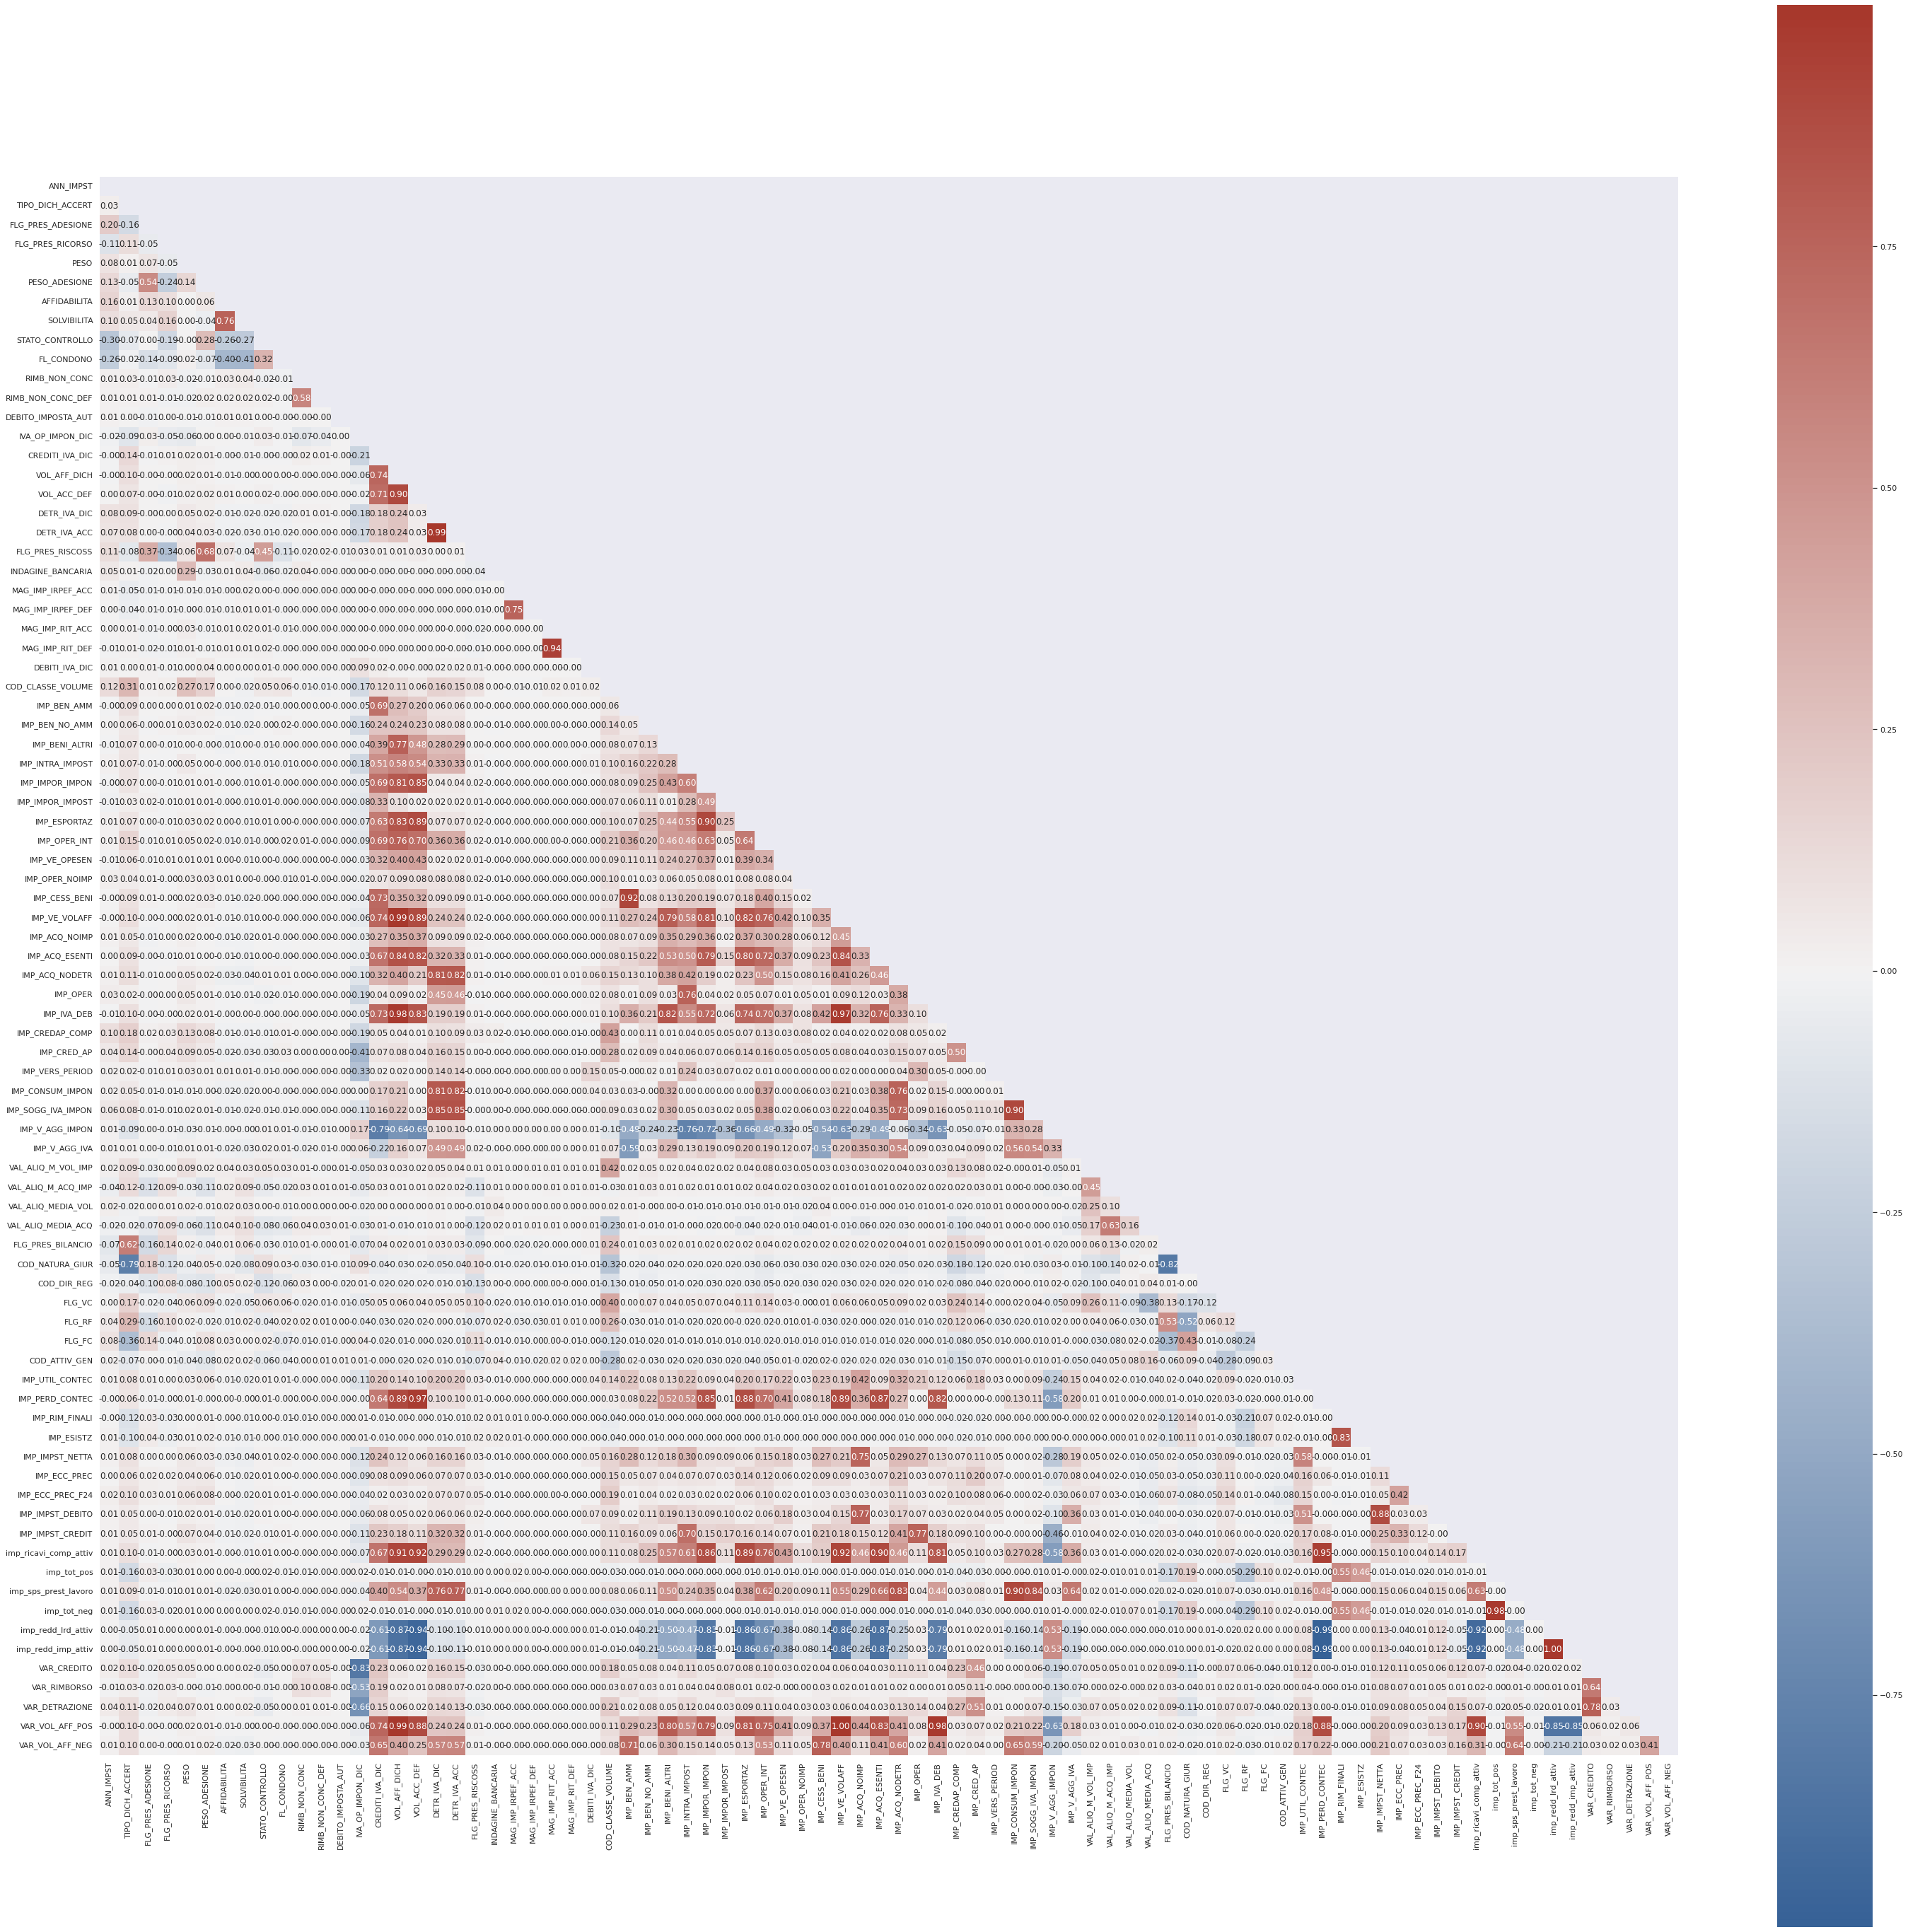

In [12]:
correlation_matrix(numeric_copy)

In [13]:
to_drop = identify_correlated(numeric_copy, threshold=0.75)
print(f"Dropping {len(to_drop)} columns:")
for c in to_drop:
    print(f"Dropping {c}")

Dropping 34 columns:
Dropping TIPO_DICH_ACCERT
Dropping AFFIDABILITA
Dropping IVA_OP_IMPON_DIC
Dropping CREDITI_IVA_DIC
Dropping VOL_AFF_DICH
Dropping VOL_ACC_DEF
Dropping DETR_IVA_DIC
Dropping DETR_IVA_ACC
Dropping MAG_IMP_IRPEF_ACC
Dropping MAG_IMP_RIT_ACC
Dropping IMP_BEN_AMM
Dropping IMP_BENI_ALTRI
Dropping IMP_INTRA_IMPOST
Dropping IMP_IMPOR_IMPON
Dropping IMP_ESPORTAZ
Dropping IMP_OPER_INT
Dropping IMP_CESS_BENI
Dropping IMP_VE_VOLAFF
Dropping IMP_ACQ_NOIMP
Dropping IMP_ACQ_ESENTI
Dropping IMP_ACQ_NODETR
Dropping IMP_OPER
Dropping IMP_IVA_DEB
Dropping IMP_CONSUM_IMPON
Dropping IMP_SOGG_IVA_IMPON
Dropping FLG_PRES_BILANCIO
Dropping IMP_PERD_CONTEC
Dropping IMP_RIM_FINALI
Dropping IMP_IMPST_NETTA
Dropping imp_ricavi_comp_attiv
Dropping imp_tot_pos
Dropping imp_redd_lrd_attiv
Dropping imp_redd_imp_attiv
Dropping VAR_CREDITO


In [14]:
numeric_copy_reduced = numeric_copy.drop(to_drop, axis=1)

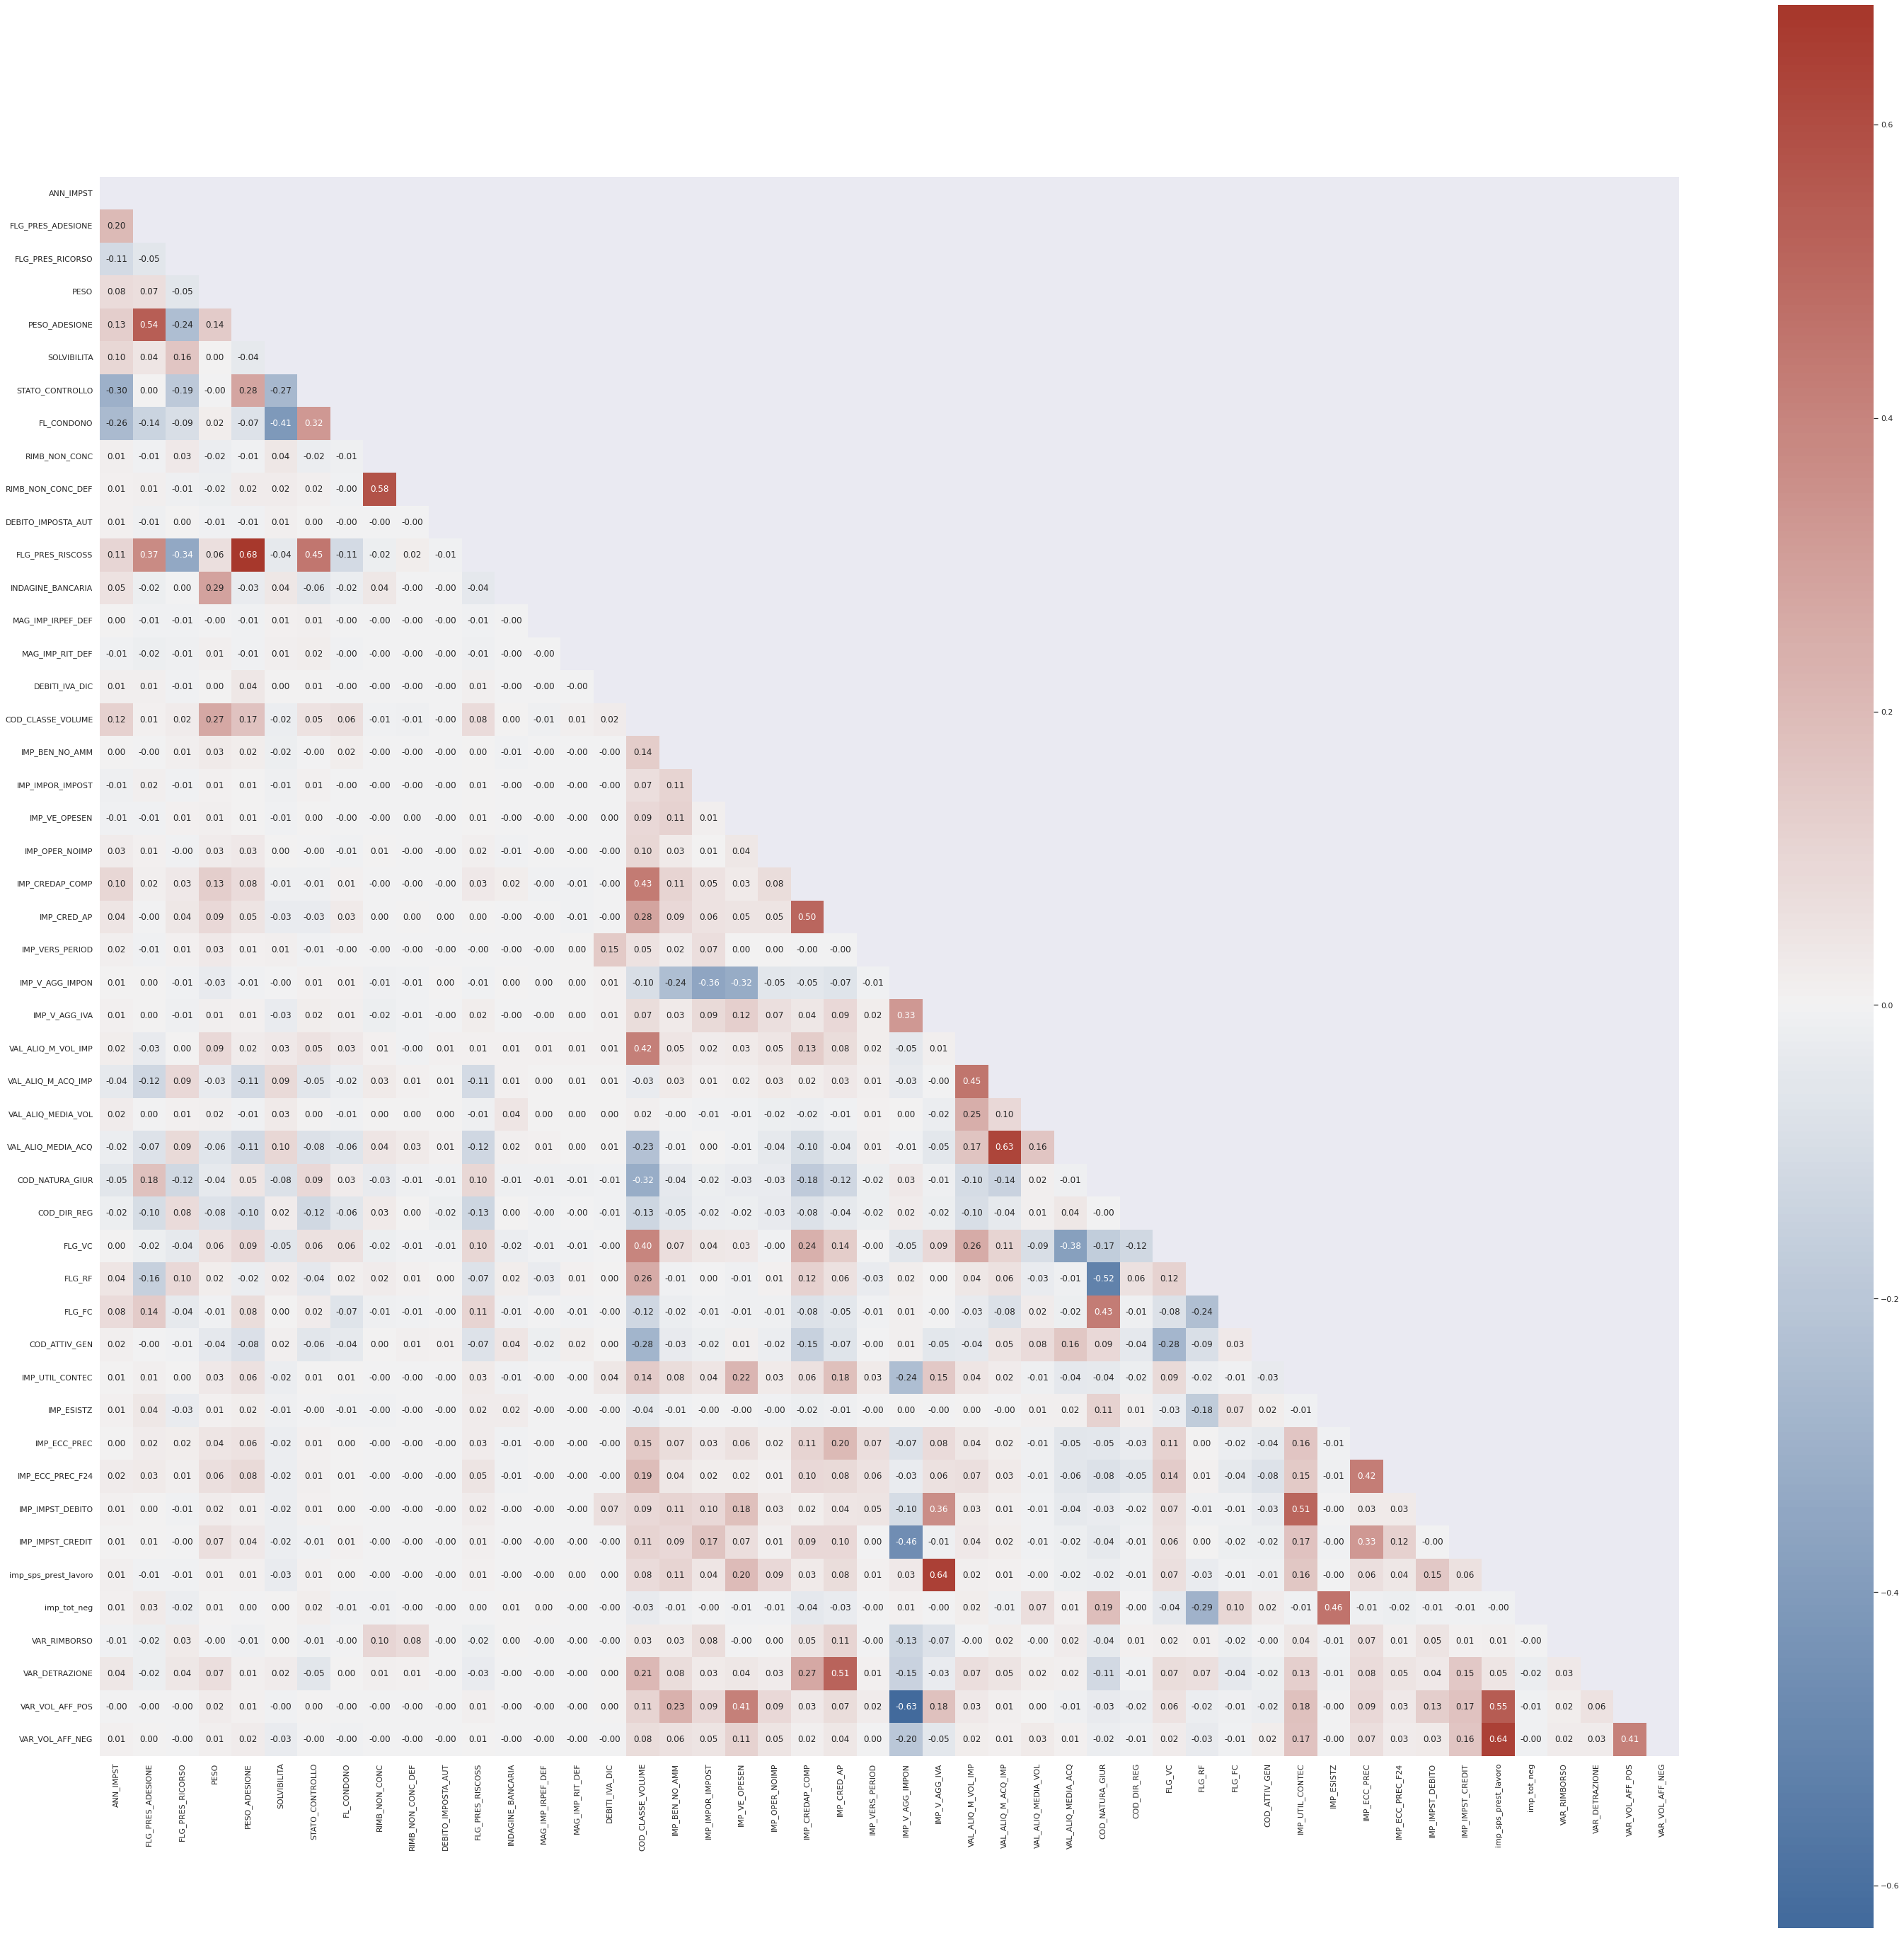

In [15]:
correlation_matrix(numeric_copy_reduced)

In [16]:
numeric_copy_reduced['Target'] = target

# Scaling the dataset

In [17]:
from sklearn.preprocessing import StandardScaler
# Scale the numerical features
scaler = StandardScaler()
feat_cols = numeric_copy_reduced.columns[:-1]
numeric_copy_reduced[feat_cols] = scaler.fit_transform(numeric_copy_reduced[feat_cols])

In [18]:
numeric_copy_reduced

,ANN_IMPST,FLG_PRES_ADESIONE,FLG_PRES_RICORSO,PESO,PESO_ADESIONE,SOLVIBILITA,STATO_CONTROLLO,FL_CONDONO,RIMB_NON_CONC,RIMB_NON_CONC_DEF,...,IMP_ECC_PREC_F24,IMP_IMPST_DEBITO,IMP_IMPST_CREDIT,imp_sps_prest_lavoro,imp_tot_neg,VAR_RIMBORSO,VAR_DETRAZIONE,VAR_VOL_AFF_POS,VAR_VOL_AFF_NEG,Target
0,0.525330,1.205881,-0.542534,0.199212,4.058525,0.228899,0.622848,-0.216617,-0.054656,-0.021763,...,0.124370,-0.043217,0.179158,0.098229,-0.13833,-0.073177,0.531387,0.080565,-0.027459,0
1,-0.856356,-0.829269,-0.542534,-0.634054,-0.449675,0.228899,0.493609,-0.216617,-0.054656,-0.021763,...,-0.117234,-0.043217,-0.054288,-0.037581,-0.13833,-0.033024,-0.215376,-0.044752,-0.035756,0
2,-0.165513,-0.829269,-0.542534,-0.634054,-0.449675,0.228899,0.881327,-0.216617,-0.054656,-0.021763,...,0.002622,-0.035326,-0.054288,-0.029966,-0.13833,-0.073177,-0.138035,-0.044641,-0.035756,0
3,-0.165513,-0.829269,-0.542534,-0.109405,-0.449675,1.194882,-1.444980,-0.216617,-0.054656,-0.021763,...,-0.117234,-0.043217,-0.054288,-0.037581,-0.13833,-0.073177,-0.201583,-0.050602,-0.035756,0
4,-0.165513,1.205881,-0.542534,-0.634054,-0.449675,0.228899,0.752088,-0.216617,-0.054656,-0.021763,...,-0.117234,-0.043217,-0.054288,-0.037581,-0.13833,-0.073177,-0.198857,-0.046994,-0.035756,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12494,0.525330,-0.829269,-0.542534,-0.634054,-0.449675,0.228899,-1.444980,-0.216617,-0.054656,-0.021763,...,-0.117234,-0.043217,-0.054288,-0.037581,-0.13833,-0.073177,0.623064,-0.050713,-0.035756,1
12495,1.907016,-0.829269,-0.542534,0.476967,-0.449675,0.228899,-1.444980,-0.216617,-0.054656,-0.021763,...,-0.117234,-0.043217,-0.053425,-0.037581,-0.13833,-0.073177,-0.103594,-0.050713,-0.035756,1
12496,0.525330,-0.829269,-0.542534,0.476967,-0.449675,0.228899,-1.444980,-0.216617,-0.054656,-0.021763,...,-0.117234,-0.043217,-0.053855,-0.037581,-0.13833,0.059303,-0.146636,-0.050713,-0.035756,1
12497,-0.165513,-0.829269,-0.542534,0.476967,-0.449675,0.228899,-1.444980,-0.216617,-0.054656,-0.021763,...,-0.117234,-0.043217,-0.054268,-0.037581,-0.13833,-0.073177,-0.178445,-0.050713,-0.035756,1


# Clustering

In [19]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from kneed import KneeLocator

CLUSTERS = [*range(2, 12)]

In [20]:
def print_metrics(X, kmeans):
    """print the metrics of the kmeans model.
    Parameters
    ----------
        X - normalized dataset
        kmeans - model.
    Prints
    ------
        K
        SSE
        Silhouette score
        Separation
    
    """
    print(f'K={len(kmeans.cluster_centers_)}')
    print('\tSSE:\t\t{}'.format(kmeans.inertia_))
    print('\tSilhouette:\t\t{}'.format(metrics.silhouette_score(X, kmeans.labels_)))
    print('\tDaviesBouldin score:\t\t{}'.format(metrics.davies_bouldin_score(X, kmeans.labels_)))

def run_kmeans(X, range_nclusters=CLUSTERS):
    '''runs kmeans for different values of k'''
    inertia, models = [], []
    for k in range_nclusters:
        k_means = KMeans(init='k-means++', n_clusters= k, n_init=20, random_state=123)
        model = k_means.fit(X) #returns fitted estimator
        models.append(model)
        inertia.append(k_means.inertia_)
    return inertia, models

def plot_silouette(data, models):
    """
    models - list of already fit kmeans models
    """
    fig, axs = plt.subplots(ncols=len(models), figsize=(15,5), sharex=True, sharey=True)
    for i,model in enumerate(models):
        nclusters = model.n_clusters
        axs[i].set_xlim([-0.1, 1])
        axs[i].set_ylim([0, len(data) + (nclusters + 1) * 10])
        axs[i].set_title(f"$K={nclusters}$")
        
        clusters = model.predict(data)
        silhouette_avg = silhouette_score(data, clusters)
        
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data, clusters)
        
        y_lower = 10
        for j in range(nclusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[clusters == j]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(j) / nclusters)
            axs[i].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            axs[i].text(-0.05, y_lower + 0.5 * size_cluster_i, str(j))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
        
        # The vertical line for average silhouette score of all the values
        axs[i].axvline(x=silhouette_avg, color="red", linestyle="--")

        axs[i].set_yticks([])  # Clear the yaxis labels / ticks
        axs[i].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        
    plt.tight_layout()

In [21]:
DATASET = numeric_copy_reduced


## Class 0
Compute the clusters for class $0$

In [22]:
zeroes = DATASET[DATASET['Target'] == 0].copy()

In [23]:
wcss_0, models_0 = run_kmeans(zeroes[feat_cols])

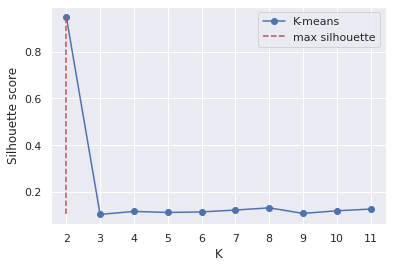

In [24]:
sil_score_0 = []
for m in models_0:
    sil_score_0.append(silhouette_score(zeroes[feat_cols], m.labels_))
    
plt.plot(CLUSTERS, sil_score_0, 'bo-', label="K-means")
plt.vlines(np.argmax(sil_score_0) + 2, min(sil_score_0), max(sil_score_0), 'r', '--', label="max silhouette")
plt.xticks(CLUSTERS)
plt.xlabel("K")
plt.xticks(range(2, 12))
plt.ylabel("Silhouette score")
plt.legend()
plt.show()

/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/kneed/knee_locator.py:304: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

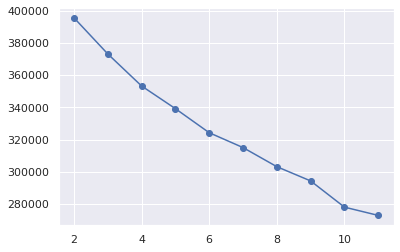

In [25]:
kl = KneeLocator(CLUSTERS, wcss_0, curve="convex", direction="decreasing")
plt.plot(CLUSTERS, wcss_0, 'o-', label="K-means")
plt.vlines(kl.elbow, min(wcss_0), max(wcss_0), 'r', '--', label="elbow")
plt.xticks(CLUSTERS)
plt.xlabel("K")
plt.ylabel("WCSS")
plt.legend()
plt.show()

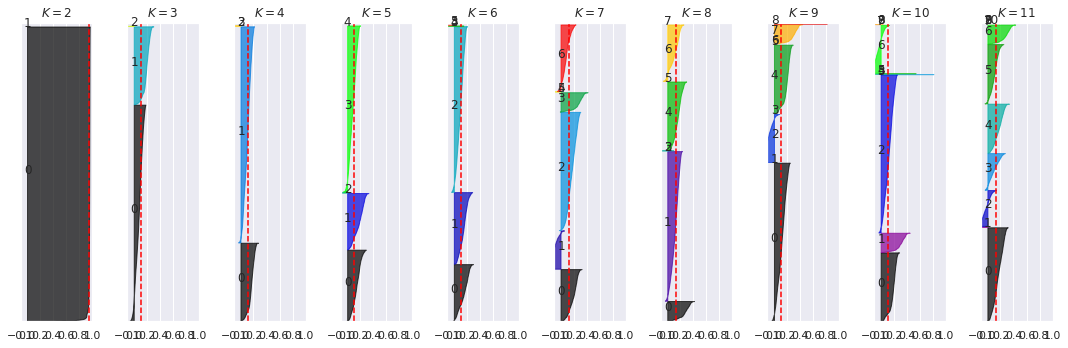

In [25]:
plot_silouette(zeroes[feat_cols], models_0[0:10])

Pick $k = 4$

In [26]:
kmeans_0 = models_0[2]
print(kmeans_0)

KMeans(n_clusters=4, n_init=20, random_state=123)


In [27]:
clusters_0 = kmeans_0.predict(zeroes[feat_cols])
centroids_0 = kmeans_0.cluster_centers_

zeroes['Cluster'] = clusters_0

zeroes

,ANN_IMPST,FLG_PRES_ADESIONE,FLG_PRES_RICORSO,PESO,PESO_ADESIONE,SOLVIBILITA,STATO_CONTROLLO,FL_CONDONO,RIMB_NON_CONC,RIMB_NON_CONC_DEF,...,IMP_IMPST_DEBITO,IMP_IMPST_CREDIT,imp_sps_prest_lavoro,imp_tot_neg,VAR_RIMBORSO,VAR_DETRAZIONE,VAR_VOL_AFF_POS,VAR_VOL_AFF_NEG,Target,Cluster
0,0.525330,1.205881,-0.542534,0.199212,4.058525,0.228899,0.622848,-0.216617,-0.054656,-0.021763,...,-0.043217,0.179158,0.098229,-0.138330,-0.073177,0.531387,0.080565,-0.027459,0,0
1,-0.856356,-0.829269,-0.542534,-0.634054,-0.449675,0.228899,0.493609,-0.216617,-0.054656,-0.021763,...,-0.043217,-0.054288,-0.037581,-0.138330,-0.033024,-0.215376,-0.044752,-0.035756,0,1
2,-0.165513,-0.829269,-0.542534,-0.634054,-0.449675,0.228899,0.881327,-0.216617,-0.054656,-0.021763,...,-0.035326,-0.054288,-0.029966,-0.138330,-0.073177,-0.138035,-0.044641,-0.035756,0,1
3,-0.165513,-0.829269,-0.542534,-0.109405,-0.449675,1.194882,-1.444980,-0.216617,-0.054656,-0.021763,...,-0.043217,-0.054288,-0.037581,-0.138330,-0.073177,-0.201583,-0.050602,-0.035756,0,1
4,-0.165513,1.205881,-0.542534,-0.634054,-0.449675,0.228899,0.752088,-0.216617,-0.054656,-0.021763,...,-0.043217,-0.054288,-0.037581,-0.138330,-0.073177,-0.198857,-0.046994,-0.035756,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,0.525330,1.205881,-0.542534,-0.942671,1.334821,0.228899,0.622848,-0.216617,-0.054656,-0.021763,...,-0.043217,-0.050207,-0.037003,-0.138330,-0.073177,0.042120,-0.050693,-0.035756,0,0
8996,-0.165513,-0.829269,-0.542534,-0.263714,-0.449675,0.228899,0.752088,-0.216617,-0.054656,-0.021763,...,-0.043217,-0.054288,-0.037581,-0.138330,-0.073177,-0.211426,-0.050318,-0.035756,0,1
8997,-0.165513,1.205881,-0.542534,-0.263714,3.119317,0.228899,0.622848,-0.216617,-0.054656,-0.021763,...,-0.032251,-0.054288,-0.015849,-0.138330,-0.073177,0.224850,-0.035410,-0.035756,0,0
8998,-0.856356,1.205881,-0.542534,-0.109405,-0.449675,0.228899,-1.444980,-0.216617,-0.054656,-0.021763,...,-0.043217,-0.054288,-0.037581,0.159126,-0.073177,-0.213253,-0.050483,-0.035756,0,1


In [28]:
zeroes['Cluster'].value_counts(normalize=False)

1    6402
0    2318
3       5
2       1
Name: Cluster, dtype: int64

In [30]:
due = zeroes[zeroes['Cluster'] == 2]

In [35]:
aaa = zeroes[zeroes.Cluster != 2]

In [36]:
aaa = zeroes[zeroes.Cluster != 3]

In [37]:
wcss_x, models_x = run_kmeans(aaa[feat_cols])

In [38]:
sil_score_0 = []
for m in models_0:
    sil_score_0.append(silhouette_score(aaa[feat_cols], m.labels_))
    
plt.plot(CLUSTERS, sil_score_0, 'bo-', label="K-means")
plt.vlines(np.argmax(sil_score_0) + 2, min(sil_score_0), max(sil_score_0), 'r', '--', label="max silhouette")
plt.xticks(CLUSTERS)
plt.xlabel("K")
plt.xticks(range(2, 12))
plt.ylabel("Silhouette score")
plt.legend()
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [8721, 8726]

/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/kneed/knee_locator.py:304: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

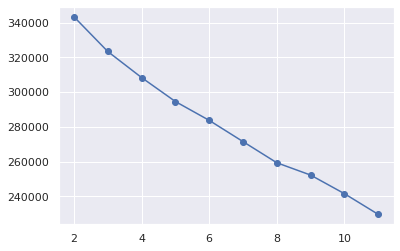

In [39]:
kl = KneeLocator(CLUSTERS, wcss_x, curve="convex", direction="decreasing")
plt.plot(CLUSTERS, wcss_x, 'o-', label="K-means")
plt.vlines(kl.elbow, min(wcss_x), max(wcss_x), 'r', '--', label="elbow")
plt.xticks(CLUSTERS)
plt.xlabel("K")
plt.ylabel("WCSS")
plt.legend()
plt.show()

## Class 1
Compute the clusters for class $1$

In [29]:
ones = DATASET[DATASET['Target'] == 1].copy()

In [30]:
ones

,ANN_IMPST,FLG_PRES_ADESIONE,FLG_PRES_RICORSO,PESO,PESO_ADESIONE,SOLVIBILITA,STATO_CONTROLLO,FL_CONDONO,RIMB_NON_CONC,RIMB_NON_CONC_DEF,...,IMP_ECC_PREC_F24,IMP_IMPST_DEBITO,IMP_IMPST_CREDIT,imp_sps_prest_lavoro,imp_tot_neg,VAR_RIMBORSO,VAR_DETRAZIONE,VAR_VOL_AFF_POS,VAR_VOL_AFF_NEG,Target
9000,0.525330,-0.829269,1.843203,-0.387160,-0.449675,1.194882,-0.281827,-0.216617,-0.054656,-0.021763,...,-0.117234,-0.043217,-0.054288,-0.037581,-0.13833,-0.073177,-0.095580,-0.050139,-0.035756,1
9001,-1.547198,1.205881,1.843203,-0.263714,-0.449675,-0.737083,-0.152587,-0.216617,-0.054656,-0.021763,...,-0.117234,-0.003659,-0.054288,-0.026697,-0.13833,-0.073177,0.130383,0.012775,-0.035756,1
9002,-0.165513,-0.829269,-0.542534,-0.263714,-0.449675,-0.737083,0.881327,-0.216617,-0.054656,-0.021763,...,-0.117234,-0.036490,-0.054288,-0.037581,-0.13833,-0.073177,-0.118094,-0.029260,-0.035756,1
9003,-0.165513,-0.829269,1.843203,0.199212,-0.449675,0.228899,-0.540305,-0.216617,-0.054656,-0.021763,...,2.918923,-0.043217,0.263317,-0.011902,-0.13833,-0.073177,0.085117,0.110274,0.432526,1
9004,0.525330,-0.829269,1.843203,-0.263714,-0.449675,0.228899,-0.540305,-0.216617,-0.054656,-0.021763,...,2.029977,-0.043217,-0.052919,-0.011692,-0.13833,-0.073177,0.643395,0.077542,-0.027223,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12494,0.525330,-0.829269,-0.542534,-0.634054,-0.449675,0.228899,-1.444980,-0.216617,-0.054656,-0.021763,...,-0.117234,-0.043217,-0.054288,-0.037581,-0.13833,-0.073177,0.623064,-0.050713,-0.035756,1
12495,1.907016,-0.829269,-0.542534,0.476967,-0.449675,0.228899,-1.444980,-0.216617,-0.054656,-0.021763,...,-0.117234,-0.043217,-0.053425,-0.037581,-0.13833,-0.073177,-0.103594,-0.050713,-0.035756,1
12496,0.525330,-0.829269,-0.542534,0.476967,-0.449675,0.228899,-1.444980,-0.216617,-0.054656,-0.021763,...,-0.117234,-0.043217,-0.053855,-0.037581,-0.13833,0.059303,-0.146636,-0.050713,-0.035756,1
12497,-0.165513,-0.829269,-0.542534,0.476967,-0.449675,0.228899,-1.444980,-0.216617,-0.054656,-0.021763,...,-0.117234,-0.043217,-0.054268,-0.037581,-0.13833,-0.073177,-0.178445,-0.050713,-0.035756,1


In [31]:
wcss_1, models_1 = run_kmeans(ones[feat_cols])

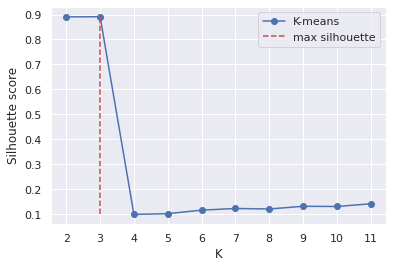

In [32]:
sil_score_1 = []
for m in models_1:
    sil_score_1.append(silhouette_score(ones[feat_cols], m.labels_))
    
plt.plot(CLUSTERS, sil_score_1, 'bo-', label="K-means")
plt.vlines(np.argmax(sil_score_1) + 2, min(sil_score_1), max(sil_score_1), 'r', '--', label="max silhouette")
plt.xticks(CLUSTERS)
plt.xlabel("K")
plt.xticks(range(2, 12))
plt.ylabel("Silhouette score")
plt.legend()
plt.show()

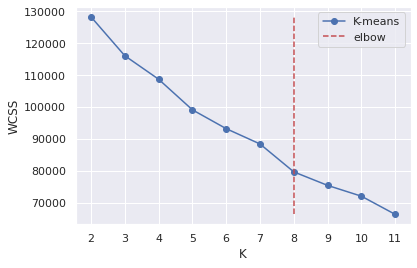

In [33]:
kl = KneeLocator(CLUSTERS, wcss_1, curve="convex", direction="decreasing")
plt.plot(CLUSTERS, wcss_1, 'o-', label="K-means")
plt.vlines(kl.elbow, min(wcss_1), max(wcss_1), 'r', '--', label="elbow")
plt.xticks(CLUSTERS)
plt.xlabel("K")
plt.ylabel("WCSS")
plt.legend()
plt.show()

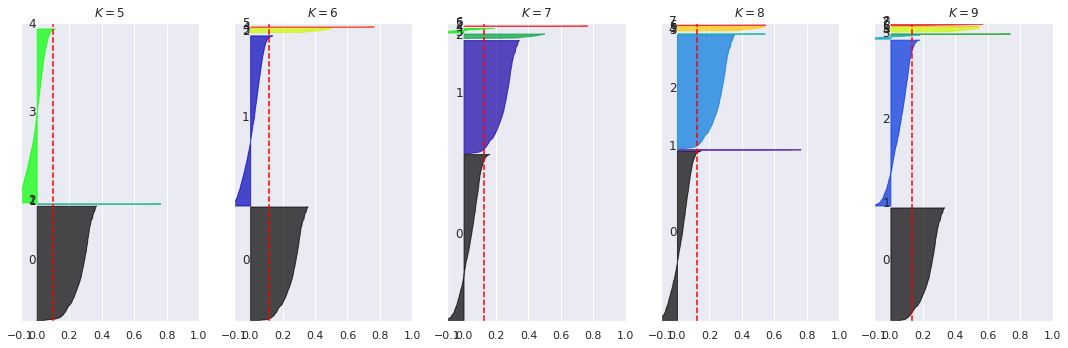

In [34]:
plot_silouette(ones[feat_cols], models_1[3:8])

Pick $k = 8$

In [35]:
kmeans_1 = models_1[6]
print(kmeans_1)

KMeans(n_init=20, random_state=123)


In [36]:
clusters_1 = kmeans_1.predict(ones[feat_cols])
centroids_1 = kmeans_1.cluster_centers_
ones['Cluster'] = clusters_1

ones

,ANN_IMPST,FLG_PRES_ADESIONE,FLG_PRES_RICORSO,PESO,PESO_ADESIONE,SOLVIBILITA,STATO_CONTROLLO,FL_CONDONO,RIMB_NON_CONC,RIMB_NON_CONC_DEF,...,IMP_IMPST_DEBITO,IMP_IMPST_CREDIT,imp_sps_prest_lavoro,imp_tot_neg,VAR_RIMBORSO,VAR_DETRAZIONE,VAR_VOL_AFF_POS,VAR_VOL_AFF_NEG,Target,Cluster
9000,0.525330,-0.829269,1.843203,-0.387160,-0.449675,1.194882,-0.281827,-0.216617,-0.054656,-0.021763,...,-0.043217,-0.054288,-0.037581,-0.13833,-0.073177,-0.095580,-0.050139,-0.035756,1,2
9001,-1.547198,1.205881,1.843203,-0.263714,-0.449675,-0.737083,-0.152587,-0.216617,-0.054656,-0.021763,...,-0.003659,-0.054288,-0.026697,-0.13833,-0.073177,0.130383,0.012775,-0.035756,1,0
9002,-0.165513,-0.829269,-0.542534,-0.263714,-0.449675,-0.737083,0.881327,-0.216617,-0.054656,-0.021763,...,-0.036490,-0.054288,-0.037581,-0.13833,-0.073177,-0.118094,-0.029260,-0.035756,1,0
9003,-0.165513,-0.829269,1.843203,0.199212,-0.449675,0.228899,-0.540305,-0.216617,-0.054656,-0.021763,...,-0.043217,0.263317,-0.011902,-0.13833,-0.073177,0.085117,0.110274,0.432526,1,0
9004,0.525330,-0.829269,1.843203,-0.263714,-0.449675,0.228899,-0.540305,-0.216617,-0.054656,-0.021763,...,-0.043217,-0.052919,-0.011692,-0.13833,-0.073177,0.643395,0.077542,-0.027223,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12494,0.525330,-0.829269,-0.542534,-0.634054,-0.449675,0.228899,-1.444980,-0.216617,-0.054656,-0.021763,...,-0.043217,-0.054288,-0.037581,-0.13833,-0.073177,0.623064,-0.050713,-0.035756,1,2
12495,1.907016,-0.829269,-0.542534,0.476967,-0.449675,0.228899,-1.444980,-0.216617,-0.054656,-0.021763,...,-0.043217,-0.053425,-0.037581,-0.13833,-0.073177,-0.103594,-0.050713,-0.035756,1,2
12496,0.525330,-0.829269,-0.542534,0.476967,-0.449675,0.228899,-1.444980,-0.216617,-0.054656,-0.021763,...,-0.043217,-0.053855,-0.037581,-0.13833,0.059303,-0.146636,-0.050713,-0.035756,1,2
12497,-0.165513,-0.829269,-0.542534,0.476967,-0.449675,0.228899,-1.444980,-0.216617,-0.054656,-0.021763,...,-0.043217,-0.054268,-0.037581,-0.13833,-0.073177,-0.178445,-0.050713,-0.035756,1,2


In [37]:
ones['Cluster'].value_counts(normalize=False)

0    1822
2    1220
6      48
7       5
1       4
3       2
4       1
5       1
Name: Cluster, dtype: int64

# Saving the centroids

In [38]:
CENTROIDS_FILE = "centroids_diva"
np.savez(CENTROIDS_FILE, class_0 = centroids_0, class_1 = centroids_1)

# Test, Training, Validation splitting

In [39]:
from sklearn.model_selection import train_test_split

In [39]:
train_test_0, validation_0 = train_test_split(zeroes, train_size=0.8, stratify=zeroes['Cluster'])
train_0, test_0 = train_test_split(train_test_0, train_size=0.7, stratify=train_test_0['Cluster'])

In [41]:
train_test_1, validation_1 = train_test_split(ones, train_size=0.8, stratify=ones['Cluster'])
train_1, test_1 = train_test_split(train_test_1, train_size=0.7, stratify=train_test_1['Cluster'])

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [40]:
df_names = ["train_0", "test_0", "validation_0", "train_1", "test_1", "validation_1"]
for i,set_ in enumerate([train_0, test_0, validation_0, train_1, test_1, validation_1]):
    df_name = df_names[i]
    set_.to_csv(df_name)

NameError: name 'train_0' is not defined

In [ ]:
# the validation set is (roughly) the 20% of the total dataset
assert abs(len(validation_0) + len(validation_1) - 0.2*len(df)) < 5
# the train set is (roughly) the 80% of the remaining dataset
assert abs(len(train_1) + len(train_0)-0.7*(len(df) - 0.2 * len(df))) < 5

In [ ]:
# check that each set has roughly the same distribution of clusters
print(zeroes['Cluster'].value_counts(normalize=True))
print(train_test_0['Cluster'].value_counts(normalize=True))
print(train_0['Cluster'].value_counts(normalize=True))
print(test_0['Cluster'].value_counts(normalize=True))
print(validation_0['Cluster'].value_counts(normalize=True))

In [ ]:
# check that each set has roughly the same distribution of clusters
print(ones['Cluster'].value_counts(normalize=True))
print(train_test_1['Cluster'].value_counts(normalize=True))
print(train_1['Cluster'].value_counts(normalize=True))
print(test_1['Cluster'].value_counts(normalize=True))
print(validation_1['Cluster'].value_counts(normalize=True))

In [ ]:
# TODO: replace df with right dataset
train_set = df.loc[train_0.index.append(train_1.index)]
test_set = df.loc[test_0.index.append(test_1.index)]
validation_set = df.loc[validation_0.index.append(validation_1.index)]

In [ ]:
train_set

In [ ]:
#add clusters to train, test and valid. sets
clus_tr = pd.concat([train_0['Cluster'], train_1['Cluster']])
train_set['Cluster'] = clus_tr

clus_te = pd.concat([test_0['Cluster'], test_1['Cluster']])
test_set['Cluster'] = clus_te

clus_val = pd.concat([validation_0['Cluster'], validation_1['Cluster']])
validation_set['Cluster'] = clus_val

In [ ]:
train_set['Target'].value_counts(normalize=True)

In [ ]:
test_set['Target'].value_counts(normalize=True)

In [ ]:
validation_set['Target'].value_counts(normalize=True)

# Creating a Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [53]:
GRID_SEARCH_HYPERPARAMS = {
    "bootstrap": [True, False],
    "max_depth": [100, 350, 500],
    "max_features": ["auto", "sqrt"],
    "min_samples_leaf": [10, 20, 50],
    "min_samples_split": [5, 10, 50],
    "n_estimators": [100, 150, 350, 500],
    "criterion": ["gini", "entropy"],
}

In [ ]:
def create_random_forest(
        x,
        y,
        hyperparameters=GRID_SEARCH_HYPERPARAMS,
        n_jobs=4
) -> RandomForestClassifier:
    """Creates a random forest classifier via grid search.

    Args:
        x (ndarray): Training input examples.
        y (ndarray): Training target values.
        hyperparameters (Dict[str, List[Any]], optional): Dictionary of hyperparameters for the grid search. Defaults to the fixed ones.
        n_jobs: Number of jobs to run in parallel in the grid search. (default 4)

    Returns:
        RandomForestClassifier: Random forest classifier.
    """

    rf = RandomForestClassifier()
    clf = HalvingGridSearchCV(rf, hyperparameters, refit=True, n_jobs=n_jobs, verbose=1)
    clf.fit(x, y)
    return clf.best_estimator_